# WAŻNE - Robimy naa kategoriach, By XB boost potraktował kolumne jako kategoryczną to trzbba zrobić X_test[col].astype("category") i w modelu dać  #enable_categorical=True,

for col in ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

model = XGBClassifier(enable_categorical=True, eval_metric="auc")

In [58]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import optuna
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


In [59]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
sub_df = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')

In [ ]:
sub_df.head()

In [ ]:
#train_df.to_csv("/kaggle/working/train_df.csv", index=False)

In [43]:
# we can create separate column with flag for -1 value
train_df['no_previous_contact'] = (train_df['pdays'] == -1).astype(int)
test_df['no_previous_contact'] = (test_df['pdays'] == -1).astype(int)

# We can create additional column with pdays only without -1 values
train_df['pdays_cleaned'] = train_df['pdays'].where(train_df['pdays'] != -1, np.nan) 
test_df['pdays_cleaned'] = test_df['pdays'].where(test_df['pdays'] != -1, np.nan) 

# We can create additional column with numeric months
#train_df['month_as_num'] = train_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})
#test_df['month_as_num'] = test_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})

###  feature ='previous'  - Drift with test data

## Feature Engineering - all possible

In [ ]:
def stability(x):
    if x=='management' or x=='technician' or x=='admin.' or x=='services':
        return 0
    elif x=='blue-collar' or x=='self-employed' or x=='entrepreneur':
        return 1
    else:
        return 2

train_df['job_stability'] = train_df['job'].apply(stability)

In [ ]:
def stability(x):
    #High
    if x=='management' or x=='entrepreneur' or x=='self-employed':
        return 0
    # Middle
    elif x=='technician' or x=='admin.' or x=='services':
        return 1
    # Low
    elif x=='blue-collar' or x=='housemaid':
        return 2
    # No earnings
    else:
        return 3

train_df['job_earnings'] = train_df['job'].apply(stability)

In [ ]:
def stability(x):
    #Not working
    if x=='retired' or x=='student' or x=='unemployed' or x=='unknown': 
        return 0
    # working
    else:
        return 1

train_df['job_is_working'] = train_df['job'].apply(stability)

In [ ]:
train_df['prev_success']=(train_df['poutcome'] == 'success').astype(int)

In [ ]:
train_df['duration_mult_age'] = train_df['duration'] * train_df['age']

In [44]:
train_df['job_and_education'] = train_df['education'] + "_" + train_df['job']

In [ ]:
train_df['contact_plus_poutcome'] = train_df['contact'] + ' ' + train_df['poutcome']

In [ ]:
def stability(x):
    if x < 30: 
        return 0
    elif x >= 30 and x <= 60:
        return 1
    else:
        return 2

train_df['age_group'] = train_df['age'].apply(stability)

In [ ]:
def month(x):
    if x < 5:
        return 0
    elif x >= 5 and x <=8:
        return 1
    else:
        return 2 

train_df['month_group'] = train_df['month_as_num'].apply(month)

In [ ]:
def duration(x):
    # short
    if x < 120:
        return 0
    # medium
    elif x >= 120 and x <=250:
        return 1
    # long
    else:
        return 2

train_df['duration_long'] = train_df['duration'].apply(duration)

In [ ]:
mapping = ({'yes':1,"no":0})
train_df['loan_code'] = train_df['loan'].map(mapping)
train_df['housing_code'] = train_df['housing'].map(mapping)

train_df['loan_plus_housing'] = (train_df['loan_code']+train_df['housing_code']).astype(int)

In [3]:
def add_no_and_unknown_counts(df):
    # Zliczanie 'NO' w kolumnach A, B, C
    df['no_count'] = df[['default', 'housing', 'loan']].eq('no').sum(axis=1)
    
    # Zliczanie 'UNKNOWN' w kolumnach D, E
    df['unknown_count'] = df[['education', 'contact','poutcome']].eq('unknown').sum(axis=1)
    
    return df

add_no_and_unknown_counts(train_df)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,no_count,unknown_count
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0,3,1
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0,3,2
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0,2,2
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0,2,2
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1,2,2
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0,3,1
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0,2,1
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0,3,1


In [ ]:
train_df.head()

In [ ]:
# train_df['day'] = train_df['day'].astype(str)

## ML Experiments 

In [ ]:
train_df.columns

In [ ]:
train_df.info()

In [ ]:
train_df.columns

In [60]:


# ==== WPROWADŹ SWOJE KOLUMNY ====
categorical_cols = [ 'job', 'marital','education','default','housing','loan','contact','month','poutcome']#,  'no_count', 'unknown_count' ]  # 'loan_plus_housing', <- wpisz swoje kolumny kategoryczne
numerical_cols = ['age','balance', 'day', 'duration', 'campaign', 'pdays' ]#'pdays']#, 'previous']    # <- wpisz swoje kolumny numeryczne
target_col = 'y'


In [61]:
# ==== WCZYTAJ DANE ====
# train_df i test_df muszą być wcześniej wczytane

df = train_df.copy()
X = df[categorical_cols + numerical_cols].copy()
y = df[target_col].copy()

# ==== ENKODOWANIE DANYCH KATEGORYCZNYCH ==== Dla CATBOOSTA MOŻNA POMINĄ TYLKO PODAĆ LISTĘ
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# for col in ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]:
#     X[col] = X[col].astype("category")

# ==== K-FOLD USTAWIENIA ====
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==== FUNKCJA TRENOWANIA MODELU ====
def train_model(X, y, params):
    scores = []
    importances = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = XGBClassifier(
            **params,
            eval_metric='auc',
            #enable_categorical=True,
            use_label_encoder=False,
            n_jobs=-1,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        )
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        importances.append(model.feature_importances_)

        print(f"Fold {fold+1} ROC-AUC: {auc:.5f}")

    print(f"\nŚredni ROC-AUC: {np.mean(scores):.5f}")
    avg_importances = np.mean(importances, axis=0)

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importances
    }).sort_values(by='importance', ascending=False)

    print("\nFeature Importances:\n", importance_df)

    # Można też narysować
    importance_df.plot.bar(x='feature', y='importance', legend=False,  figsize=(10,5))
    plt.title("Średnia ważność cech (feature importance)")
    plt.show()

In [ ]:
# ==== OPCJA 1: GRID SEARCH ====
def grid_search():
    param_grid = {
        'max_depth': [3],#, 5],
        'learning_rate': [0.1],#, 0.05],
        'n_estimators': [100, 200],
        'subsample': [0.8]#, 1.0]
    }

    best_score = -np.inf
    best_params = None

    from itertools import product

    keys, values = zip(*param_grid.items())
    for combination in product(*values):
        params = dict(zip(keys, combination))
        print("\nSprawdzam parametry:", params)
        try:
            train_model(X, y, params)
            # Jeżeli chcesz, dodaj kod do zapisu najlepszego modelu tutaj
        except Exception as e:
            print("Błąd:", e)

In [ ]:
grid_search()

In [62]:
def optuna_search(n_trials=30):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            # 'max_depth': trial.suggest_int('max_depth', 3, 11),
            # 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            # 'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            # 'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            # 'gamma': trial.suggest_float('gamma', 0, 5),
            # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
        }

        scores = []
        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

            model = XGBClassifier(
                **params,
                eval_metric='auc',
                use_label_encoder=False,
                n_jobs=-1,
                scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
            )

            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("\nNajlepsze parametry Optuna:\n", study.best_params)
    print(f"Najlepszy ROC-AUC: {study.best_value:.5f}")

    # Trenowanie najlepszego modelu na koniec
    train_model(X, y, study.best_params)

[I 2025-08-12 12:30:19,417] A new study created in memory with name: no-name-de8e34c9-b09f-4c65-ac0b-b4ff7af2eaa1
[I 2025-08-12 12:31:49,423] Trial 0 finished with value: 0.9658478505493469 and parameters: {'max_depth': 8, 'learning_rate': 0.15192834899802224, 'n_estimators': 418, 'subsample': 0.700674728453436, 'colsample_bytree': 0.8984852100341959}. Best is trial 0 with value: 0.9658478505493469.
[I 2025-08-12 12:38:53,782] Trial 1 finished with value: 0.966550245414642 and parameters: {'max_depth': 13, 'learning_rate': 0.011207209563395631, 'n_estimators': 881, 'subsample': 0.8918122011955865, 'colsample_bytree': 0.7503862949281848}. Best is trial 1 with value: 0.966550245414642.
[I 2025-08-12 12:39:33,474] Trial 2 finished with value: 0.9659717390824047 and parameters: {'max_depth': 11, 'learning_rate': 0.12039695029122309, 'n_estimators': 117, 'subsample': 0.882104955801144, 'colsample_bytree': 0.8840059660577697}. Best is trial 1 with value: 0.966550245414642.
[I 2025-08-12 12:4


Najlepsze parametry Optuna:
 {'max_depth': 5, 'learning_rate': 0.10673899558821162, 'n_estimators': 869, 'subsample': 0.762762355370107, 'colsample_bytree': 0.788241632330743}
Najlepszy ROC-AUC: 0.96724
Fold 1 ROC-AUC: 0.96790
Fold 2 ROC-AUC: 0.96656
Fold 3 ROC-AUC: 0.96664
Fold 4 ROC-AUC: 0.96789
Fold 5 ROC-AUC: 0.96721

Średni ROC-AUC: 0.96724

Feature Importances:
       feature  importance
12   duration    0.281779
6     contact    0.205736
4     housing    0.144281
8    poutcome    0.079596
7       month    0.059700
5        loan    0.048112
14      pdays    0.035842
10    balance    0.024147
1     marital    0.022812
2   education    0.022120
13   campaign    0.018777
11        day    0.018735
9         age    0.016284
0         job    0.014423
3     default    0.007657


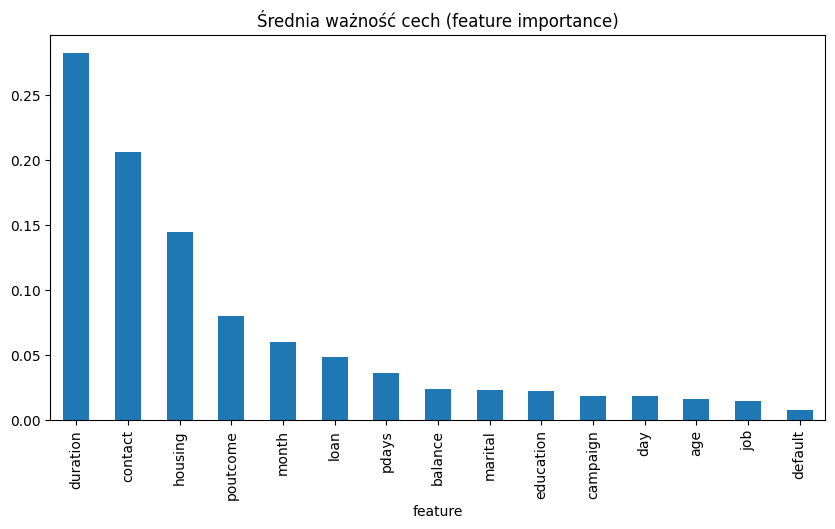

In [63]:
optuna_search(n_trials=30)

In [ ]:
# RAW DATA  With optuna XGBoost
# Public LB Score = 0.96878 bez CV w Submission
# Public LB Score = 0.96924 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.088542375425159, 'n_estimators': 353, 'subsample': 0.7933680125492807, 'colsample_bytree': 0.665859932215261, 'gamma': 1.9591038948726576, 'reg_alpha': 4.135658777432998, 'reg_lambda': 3.0378978111339086}
Najlepszy ROC-AUC: 0.96788
Fold 1 ROC-AUC: 0.96859
Fold 2 ROC-AUC: 0.96726
Fold 3 ROC-AUC: 0.96728
Fold 4 ROC-AUC: 0.96853
Fold 5 ROC-AUC: 0.96773

Średni ROC-AUC: 0.96788

Feature Importances:
       feature  importance
12   duration    0.255548
6     contact    0.171966
4     housing    0.160483
8    poutcome    0.070366
7       month    0.061991
14      pdays    0.056551
5        loan    0.044870
10    balance    0.037885
11        day    0.022941
1     marital    0.022816
13   campaign    0.021023
9         age    0.017168
2   education    0.016198
0         job    0.015291
15   previous    0.013801
3     default    0.011103

In [ ]:
# RAW DATA  With optuna XGBoost bez cechy previous 
# Public LB Score = 0.96914 bez z CV w Submission 
# Public LB Score = 0.96942  z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.11410300715659989, 'n_estimators': 368, 'subsample': 0.907977121199552, 'colsample_bytree': 0.6014268962223818, 'gamma': 0.7012459904827175, 'reg_alpha': 4.361523501536162, 'reg_lambda': 4.294305690785547}
Najlepszy ROC-AUC: 0.96787
Fold 1 ROC-AUC: 0.96860
Fold 2 ROC-AUC: 0.96714
Fold 3 ROC-AUC: 0.96721
Fold 4 ROC-AUC: 0.96854
Fold 5 ROC-AUC: 0.96785

Średni ROC-AUC: 0.96787

Feature Importances:
       feature  importance
12   duration    0.361053
6     contact    0.166310
4     housing    0.132702
8    poutcome    0.083217
7       month    0.062788
5        loan    0.041027
14      pdays    0.026778
10    balance    0.024013
11        day    0.019122
2   education    0.016243
13   campaign    0.016015
1     marital    0.015528
9         age    0.015053
0         job    0.011771
3     default    0.008379

In [ ]:
# RAW DATA  With optuna XGBoost bez cechy previous  / z enable_categorical=True (XGBoost sam obsługuje kategorie)
# Public LB Score = 0.96844 bez CV w Submission
# Public LB Score = 0.96891 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 8, 'learning_rate': 0.07733762308533498, 'n_estimators': 469, 'subsample': 0.9190881144681935, 'colsample_bytree': 0.7461531023839627, 'gamma': 2.06998675412871, 'reg_alpha': 1.3641260353935682, 'reg_lambda': 4.343504135311625}
Najlepszy ROC-AUC: 0.96775
Fold 1 ROC-AUC: 0.96845
Fold 2 ROC-AUC: 0.96711
Fold 3 ROC-AUC: 0.96709
Fold 4 ROC-AUC: 0.96834
Fold 5 ROC-AUC: 0.96777

Średni ROC-AUC: 0.96775

Feature Importances:
       feature  importance
12   duration    0.324780
6     contact    0.173031
4     housing    0.120737
8    poutcome    0.118197
7       month    0.067933
5        loan    0.038657
14      pdays    0.029699
10    balance    0.022180
11        day    0.019063
1     marital    0.017264
0         job    0.016717
13   campaign    0.016680
9         age    0.013868
2   education    0.011933
3     default    0.009262

In [ ]:

# optuna XGBoost bez cechy previous bez enable_categorical=True, pdays rozdzielone, 'days' jako cat, loan_plus_housing, deep_debt
# Public LB Score = 0.96848 bez CV w Submission
# Public LB Score = 0.96886 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.07135259874564061, 'n_estimators': 530, 'subsample': 0.8521429564138164, 'colsample_bytree': 0.7823863939520701, 'gamma': 2.9329829182260148, 'reg_alpha': 3.2901322430190185, 'reg_lambda': 1.268405294791835}
Najlepszy ROC-AUC: 0.96765
Fold 1 ROC-AUC: 0.96834
Fold 2 ROC-AUC: 0.96694
Fold 3 ROC-AUC: 0.96709
Fold 4 ROC-AUC: 0.96824
Fold 5 ROC-AUC: 0.96761

Średni ROC-AUC: 0.96765

Feature Importances:
                 feature  importance
15             duration    0.239886
6               contact    0.185347
10    loan_plus_housing    0.145455
9   no_previous_contact    0.078178
8              poutcome    0.052764
7                 month    0.051926
17        pdays_cleaned    0.048056
4               housing    0.045511
14              balance    0.025864
5                  loan    0.018386
1               marital    0.018161
16             campaign    0.017235
12                  day    0.016298
2             education    0.014973
13                  age    0.013090
0                   job    0.011265
3               default    0.009477
11            deep_debt    0.008127

In [ ]:
# optuna XGBoost bez cechy previous bez enable_categorical=True, pdays rozdzielone, 'days' jako num, loan_plus_housing
# Public LB Score = 0.96870 bez CV w Submission
# Public LB Score = 0.96895 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 8, 'learning_rate': 0.12763052427108496, 'n_estimators': 411, 'subsample': 0.953989568332575, 'colsample_bytree': 0.6023438935073028, 'gamma': 0.019491768244553676, 'reg_alpha': 3.961328967768697, 'reg_lambda': 1.131707666650681}

Najlepszy ROC-AUC: 0.96782
Fold 1 ROC-AUC: 0.96848
Fold 2 ROC-AUC: 0.96723
Fold 3 ROC-AUC: 0.96712
Fold 4 ROC-AUC: 0.96847
Fold 5 ROC-AUC: 0.96778

Średni ROC-AUC: 0.96782

Feature Importances:
                 feature  importance
13             duration    0.276787
6               contact    0.190028
10    loan_plus_housing    0.082526
9   no_previous_contact    0.079404
4               housing    0.067073
7                 month    0.058600
15        pdays_cleaned    0.042893
8              poutcome    0.041466
12              balance    0.033900
5                  loan    0.023026
16                  day    0.020086
14             campaign    0.020008
11                  age    0.016162
1               marital    0.014663
2             education    0.013929
3               default    0.009995
0                   job    0.009455

In [ ]:
# optuna XGBoost bez cechy previous bez enable_categorical=True, pdays rozdzielone, 'days' jako num, loan_plus_housing + col no_count + unknown_count
# Public LB Score = 96831 bez CV w Submission
# Public LB Score = 0.96867 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 7, 'learning_rate': 0.16686222138398568, 'n_estimators': 359, 'subsample': 0.9687425335082887, 'colsample_bytree': 0.8948829860260885, 'gamma': 0.3972938375538543, 'reg_alpha': 4.575416910972401, 'reg_lambda': 2.201098085025244}

Najlepszy ROC-AUC: 0.96756
Fold 1 ROC-AUC: 0.96836
Fold 2 ROC-AUC: 0.96696
Fold 3 ROC-AUC: 0.96680
Fold 4 ROC-AUC: 0.96824
Fold 5 ROC-AUC: 0.96744

Średni ROC-AUC: 0.96756

Feature Importances:
                 feature  importance
11             no_count    0.273360
15             duration    0.209798
6               contact    0.118712
12        unknown_count    0.075067
9   no_previous_contact    0.067390
7                 month    0.044799
17        pdays_cleaned    0.040017
8              poutcome    0.038668
14              balance    0.016463
2             education    0.015356
10    loan_plus_housing    0.013421
5                  loan    0.013264
18                  day    0.013007
4               housing    0.012936
16             campaign    0.012547
1               marital    0.012498
13                  age    0.009314
0                   job    0.007695
3               default    0.005689

In [ ]:
# optuna XGBoost bez cechy previous bez enable_categorical=True, pdays rozdzielone, 'days' jako num + col no_count + unknown_count  --bez loan_plus_housing - 
# Public LB Score = 0.96883 bez CV w Submission
# Public LB Score = 0.96900 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.05576641173716932, 'n_estimators': 492, 'subsample': 0.7568779660915822, 'colsample_bytree': 0.6384212073745787, 'gamma': 2.0698430928317997, 'reg_alpha': 2.9165075287479447, 'reg_lambda': 2.040935203862332}

Najlepszy ROC-AUC: 0.96792
Fold 1 ROC-AUC: 0.96869
Fold 2 ROC-AUC: 0.96731
Fold 3 ROC-AUC: 0.96734
Fold 4 ROC-AUC: 0.96847
Fold 5 ROC-AUC: 0.96779

Średni ROC-AUC: 0.96792

Feature Importances:
                 feature  importance
14             duration    0.241594
10             no_count    0.142254
6               contact    0.121863
9   no_previous_contact    0.109933
11        unknown_count    0.057236
7                 month    0.056043
8              poutcome    0.044780
16        pdays_cleaned    0.040740
4               housing    0.033472
5                  loan    0.022579
13              balance    0.022401
17                  day    0.018681
15             campaign    0.018105
1               marital    0.017343
2             education    0.015570
12                  age    0.014035
0                   job    0.011947
3               default    0.011424

In [ ]:
# RAW DATA  With optuna XGBoost bez cechy previous + pdays rozdzielone
# Public LB Score = ----------- bez z CV w Submission 
# Public LB Score = 0.96911 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.0832583908499121, 'n_estimators': 551, 'subsample': 0.8758220883852462, 'colsample_bytree': 0.6810585417529508, 'gamma': 2.389202320659961, 'reg_alpha': 0.9587487104983587, 'reg_lambda': 4.103575772005836}
Najlepszy ROC-AUC: 0.96779
Fold 1 ROC-AUC: 0.96867
Fold 2 ROC-AUC: 0.96720
Fold 3 ROC-AUC: 0.96721
Fold 4 ROC-AUC: 0.96839
Fold 5 ROC-AUC: 0.96750

Średni ROC-AUC: 0.96779

Feature Importances:
                 feature  importance
13             duration    0.243189
4               housing    0.139019
6               contact    0.138376
9   no_previous_contact    0.123810
8              poutcome    0.074177
7                 month    0.060123
5                  loan    0.039687
15        pdays_cleaned    0.038699
11              balance    0.027620
12                  day    0.020040
1               marital    0.019900
14             campaign    0.018159
10                  age    0.015864
2             education    0.015750
0                   job    0.014219
3               default    0.011369

In [ ]:
# RAW DATA  With optuna XGBoost bez cechy previous  + col no_count
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96901 z CV w Submission 

Najlepsze parametry Optuna:
 {'max_depth': 11, 'learning_rate': 0.07256654502258869, 'n_estimators': 264, 'subsample': 0.7252245807583018, 'colsample_bytree': 0.7225278113013671, 'gamma': 3.044364512727718, 'reg_alpha': 4.9552240198208874, 'reg_lambda': 3.7933495200093277}
Najlepszy ROC-AUC: 0.96786
Fold 1 ROC-AUC: 0.96868
Fold 2 ROC-AUC: 0.96723
Fold 3 ROC-AUC: 0.96730
Fold 4 ROC-AUC: 0.96846
Fold 5 ROC-AUC: 0.96764

Średni ROC-AUC: 0.96786

Feature Importances:
       feature  importance
13   duration    0.261933
6     contact    0.184296
9    no_count    0.156206
4     housing    0.073811
8    poutcome    0.064446
7       month    0.057004
15      pdays    0.043390
11    balance    0.026560
5        loan    0.025262
12        day    0.018575
1     marital    0.018476
14   campaign    0.017962
2   education    0.014880
10        age    0.014734
0         job    0.012134
3     default    0.010333

In [ ]:
# RAW DATA  With optuna XGBoost bez cechy previous   + col unknown_count
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96913 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 11, 'learning_rate': 0.05314481725365295, 'n_estimators': 485, 'subsample': 0.6616608475014232, 'colsample_bytree': 0.6827154636682595, 'gamma': 1.99699754127895, 'reg_alpha': 3.8063665621075478, 'reg_lambda': 1.325699284371194}
Najlepszy ROC-AUC: 0.96787
Fold 1 ROC-AUC: 0.96866
Fold 2 ROC-AUC: 0.96720
Fold 3 ROC-AUC: 0.96733
Fold 4 ROC-AUC: 0.96837
Fold 5 ROC-AUC: 0.96778

Średni ROC-AUC: 0.96787

Feature Importances:
           feature  importance
13       duration    0.246059
4         housing    0.147026
6         contact    0.120959
9   unknown_count    0.095596
8        poutcome    0.083078
7           month    0.063654
5            loan    0.042798
15          pdays    0.040915
11        balance    0.030914
12            day    0.022072
1         marital    0.021628
14       campaign    0.020466
2       education    0.018847
10            age    0.018099
0             job    0.015135
3         default    0.012754

# __________________ NOWE EXPERYMENTY _____________________

In [ ]:
## Sprawdź job_edu matrix
# RAW DATA  With optuna XGBoost bez cechy previous   + col job_edu
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96913 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.08212321514497181, 'n_estimators': 523, 'subsample': 0.7525320809093057, 'colsample_bytree': 0.6765190265893073, 'gamma': 3.0377809209553503, 'reg_alpha': 3.625755897052336, 'reg_lambda': 0.18705008615849394}
Najlepszy ROC-AUC: 0.96773
Fold 1 ROC-AUC: 0.96851
Fold 2 ROC-AUC: 0.96708
Fold 3 ROC-AUC: 0.96716
Fold 4 ROC-AUC: 0.96832
Fold 5 ROC-AUC: 0.96758

Średni ROC-AUC: 0.96773

Feature Importances:
               feature  importance
13           duration    0.260276
4             housing    0.164296
6             contact    0.159799
8            poutcome    0.090988
7               month    0.066868
5                loan    0.045981
15              pdays    0.039986
11            balance    0.030999
12                day    0.022041
1             marital    0.021875
14           campaign    0.020257
10                age    0.017447
2           education    0.016907
0                 job    0.015690
9   job_and_education    0.013969
3             default    0.012622

In [ ]:
# bez weight balanced
# RAW DATA  With optuna XGBoost bez cechy previous, no XGB weight balanced
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score =  z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 11, 'learning_rate': 0.11206031547278855, 'n_estimators': 501, 'subsample': 0.6131323770348673, 'colsample_bytree': 0.6094568889243491, 'gamma': 2.043078715855179, 'reg_alpha': 2.0852138450654643, 'reg_lambda': 4.796903414902333}
Najlepszy ROC-AUC: 0.96812
Fold 1 ROC-AUC: 0.96889
Fold 2 ROC-AUC: 0.96754
Fold 3 ROC-AUC: 0.96766
Fold 4 ROC-AUC: 0.96853
Fold 5 ROC-AUC: 0.96799

Średni ROC-AUC: 0.96812

Feature Importances:
       feature  importance
12   duration    0.222174
4     housing    0.181200
6     contact    0.177984
8    poutcome    0.135613
5        loan    0.054855
7       month    0.054545
14      pdays    0.029267
10    balance    0.021182
13   campaign    0.021124
11        day    0.021034
2   education    0.020611
1     marital    0.019631
9         age    0.017880
0         job    0.013251
3     default    0.009648

In [ ]:
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),

In [ ]:
## 10 folds no previuous 

In [ ]:
## 10 folds z previous 

In [ ]:
## CV 10 folds no previuous i z previous // n_trials = 100 

In [ ]:
# n estimators 20000 i erly stopping

In [ ]:
# CATBOOST LIGHTXGBoost

In [56]:

a=[
{'Model': 'XGBClassifier','avg ROC-AUC':0.96788 , 'Public LB CV': 0.96924, 'Public LB no CV': 0.96878, 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*Raw data', 'Best params': {'max_depth': 10, 'learning_rate': 0.088542375425159, 'n_estimators': 353, 'subsample': 0.7933680125492807, 'colsample_bytree': 0.665859932215261, 'gamma': 1.9591038948726576, 'reg_alpha': 4.135658777432998, 'reg_lambda': 3.0378978111339086}}, 
{'Model': 'XGBClassifier','avg ROC-AUC':0.96787 , 'Public LB CV': 0.96942, 'Public LB no CV': 0.96914, 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous', 'Best params':  {'max_depth': 9, 'learning_rate': 0.11410300715659989, 'n_estimators': 368, 'subsample': 0.907977121199552, 'colsample_bytree': 0.6014268962223818, 'gamma': 0.7012459904827175, 'reg_alpha': 4.361523501536162, 'reg_lambda': 4.294305690785547}},
{'Model': 'XGBClassifier','avg ROC-AUC':0.96775 , 'Public LB CV': 0.96891, 'Public LB no CV': 0.96844, 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous, *enable_categorical=True XGBoost', 'Best params':  {'max_depth': 8, 'learning_rate': 0.07733762308533498, 'n_estimators': 469, 'subsample': 0.9190881144681935, 'colsample_bytree': 0.7461531023839627, 'gamma': 2.06998675412871, 'reg_alpha': 1.3641260353935682, 'reg_lambda': 4.343504135311625}},
{'Model': 'XGBClassifier','avg ROC-AUC':0.96765 , 'Public LB CV': 0.96886, 'Public LB no CV': 0.96848, 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous, *col pdays split in 2, *days as category, * new 2col loan_plus_housing, deep_debt', 'Best params':  {'max_depth': 9, 'learning_rate': 0.07135259874564061, 'n_estimators': 530, 'subsample': 0.8521429564138164, 'colsample_bytree': 0.7823863939520701, 'gamma': 2.9329829182260148, 'reg_alpha': 3.2901322430190185, 'reg_lambda': 1.268405294791835}},
{'Model': 'XGBClassifier','avg ROC-AUC':0.96782 , 'Public LB CV': 0.96895, 'Public LB no CV': 0.96870, 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous, *col pdays split in 2, *days as category, * new 1col loan_plus_housing,', 'Best params': {'max_depth': 8, 'learning_rate': 0.12763052427108496, 'n_estimators': 411, 'subsample': 0.953989568332575, 'colsample_bytree': 0.6023438935073028, 'gamma': 0.019491768244553676, 'reg_alpha': 3.961328967768697, 'reg_lambda': 1.131707666650681} },
{'Model': 'XGBClassifier','avg ROC-AUC':0.96756 , 'Public LB CV': 0.96867, 'Public LB no CV': 0.96831, 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous, *col pdays split in 2, *days as category, * new 3col loan_plus_housing, no_count, unknown_count', 'Best params': {'max_depth': 7, 'learning_rate': 0.16686222138398568, 'n_estimators': 359, 'subsample': 0.9687425335082887, 'colsample_bytree': 0.8948829860260885, 'gamma': 0.3972938375538543, 'reg_alpha': 4.575416910972401, 'reg_lambda': 2.201098085025244} },
{'Model': 'XGBClassifier','avg ROC-AUC':0.96792 , 'Public LB CV': 0.96900, 'Public LB no CV': 0.96883, 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous, *col pdays split in 2, *days as category, * new 2col no_count, unknown_count', 'Best params': {'max_depth': 10, 'learning_rate': 0.05576641173716932, 'n_estimators': 492, 'subsample': 0.7568779660915822, 'colsample_bytree': 0.6384212073745787, 'gamma': 2.0698430928317997, 'reg_alpha': 2.9165075287479447, 'reg_lambda': 2.040935203862332} },
{'Model': 'XGBClassifier','avg ROC-AUC':0.96779 , 'Public LB CV': 0.96911, 'Public LB no CV': np.nan,  'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous, *col pdays split in 2,', 'Best params': {'max_depth': 10, 'learning_rate': 0.0832583908499121, 'n_estimators': 551, 'subsample': 0.8758220883852462, 'colsample_bytree': 0.6810585417529508, 'gamma': 2.389202320659961, 'reg_alpha': 0.9587487104983587, 'reg_lambda': 4.103575772005836} },
{'Model': 'XGBClassifier','avg ROC-AUC':0.96786 , 'Public LB CV': 0.96901, 'Public LB no CV': np.nan,  'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous, *new col no_count,', 'Best params': {'max_depth': 11, 'learning_rate': 0.07256654502258869, 'n_estimators': 264, 'subsample': 0.7252245807583018, 'colsample_bytree': 0.7225278113013671, 'gamma': 3.044364512727718, 'reg_alpha': 4.9552240198208874, 'reg_lambda': 3.7933495200093277} },
{'Model': 'XGBClassifier','avg ROC-AUC':0.96787 , 'Public LB CV': 0.96913, 'Public LB no CV': np.nan,  'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '*no col previous, *new col unknown_count,', 'Best params': {'max_depth': 11, 'learning_rate': 0.05314481725365295, 'n_estimators': 485, 'subsample': 0.6616608475014232, 'colsample_bytree': 0.6827154636682595, 'gamma': 1.99699754127895, 'reg_alpha': 3.8063665621075478, 'reg_lambda': 1.325699284371194} },
#{'Model': 'XGBClassifier','avg ROC-AUC': , 'Public LB CV': , 'Public LB no CV': , 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '', 'Best params':  },
#{'Model': 'XGBClassifier','avg ROC-AUC': , 'Public LB CV': , 'Public LB no CV': , 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '', 'Best params':  },
#{'Model': 'XGBClassifier','avg ROC-AUC': , 'Public LB CV': , 'Public LB no CV': , 'Optuna n-trial': 30,  'CV folds-train': 5, 'conditions': '', 'Best params':  },
  ]


In [57]:
df_a = pd.DataFrame(a)
df_a

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Model,avg ROC-AUC,Public LB CV,Public LB no CV,Optuna n-trial,CV folds-train,conditions,Best params
0,XGBClassifier,0.96788,0.96924,0.96878,30,5,*Raw data,"{'max_depth': 10, 'learning_rate': 0.088542375..."
1,XGBClassifier,0.96787,0.96942,0.96914,30,5,*no col previous,"{'max_depth': 9, 'learning_rate': 0.1141030071..."
2,XGBClassifier,0.96775,0.96891,0.96844,30,5,"*no col previous, *enable_categorical=True XGB...","{'max_depth': 8, 'learning_rate': 0.0773376230..."
3,XGBClassifier,0.96765,0.96886,0.96848,30,5,"*no col previous, *col pdays split in 2, *days...","{'max_depth': 9, 'learning_rate': 0.0713525987..."
4,XGBClassifier,0.96782,0.96895,0.96870,30,5,"*no col previous, *col pdays split in 2, *days...","{'max_depth': 8, 'learning_rate': 0.1276305242..."
5,XGBClassifier,0.96756,0.96867,0.96831,30,5,"*no col previous, *col pdays split in 2, *days...","{'max_depth': 7, 'learning_rate': 0.1668622213..."
6,XGBClassifier,0.96792,0.96900,0.96883,30,5,"*no col previous, *col pdays split in 2, *days...","{'max_depth': 10, 'learning_rate': 0.055766411..."
7,XGBClassifier,0.96779,0.96911,NaN,30,5,"*no col previous, *col pdays split in 2,","{'max_depth': 10, 'learning_rate': 0.083258390..."
8,XGBClassifier,0.96786,0.96901,NaN,30,5,"*no col previous, *new col no_count,","{'max_depth': 11, 'learning_rate': 0.072566545..."
9,XGBClassifier,0.96787,0.96913,NaN,30,5,"*no col previous, *new col unknown_count,","{'max_depth': 11, 'learning_rate': 0.053144817..."


In [ ]:
import optuna
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

def optuna_search(n_trials=30, early_stopping_rounds=300):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 11),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'n_estimators': 10000,  # stała wartość, early stopping to ograniczy
            'eval_metric': 'auc',
            'use_label_encoder': False,
            'n_jobs': -1
        }

        scores = []
        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

            model = XGBClassifier(**params,
                                  scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=early_stopping_rounds,
                verbose=False
            )

            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("\n🎯 Najlepsze parametry Optuna:\n", study.best_params)
    print(f"🏆 Najlepszy ROC-AUC: {study.best_value:.5f}")

    # Trenowanie najlepszego modelu na całych danych
    best_params = study.best_params
    best_params['n_estimators'] = 10000
    best_params['eval_metric'] = 'auc'
    best_params['use_label_encoder'] = False
    best_params['n_jobs'] = -1

    final_model = XGBClassifier(**best_params,
                                scale_pos_weight=(y == 0).sum() / (y == 1).sum())

    final_model.fit(X, y, early_stopping_rounds=early_stopping_rounds, eval_set=[(X, y)], verbose=False)

    return final_model

In [ ]:
# Po zakończeniu fitowania z eval_set i early_stopping
best_n_estimators = model.best_iteration

# Trenujesz finalny model na całym zbiorze danych:
final_model = XGBClassifier(
    **study.best_params,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='auc',
    n_jobs=-1
)

final_model.fit(X, y)

 Uwagi:
To podejście łączy maksymalne wykorzystanie danych z optymalną liczbą iteracji.

Jest to powszechnie używana technika w realnych projektach.

Warto zapisać best_iteration po każdej foldzie podczas cross-validacji i np. uśrednić, jeśli chcesz mieć bardziej ogólny n_estimators.